In [ ]:
#!pip install modin[ray]
#!pip install -U ipywidgets

In [1]:
import requests
from xml.etree import ElementTree as ET
import pandas as pd
#import modin.pandas as pd
import os
import concurrent.futures

In [2]:
os.makedirs("raw_data", exist_ok=True)

In [3]:
endpoint = 'https://storage.googleapis.com/validaciones_tmsa/'
def descargar_archivo(carpeta_destino, destino, url = endpoint):
    file = os.path.join(carpeta_destino, destino.split('/')[-1])
    print(f'Descargando {file}...')
    response_headers = requests.head(url+destino)
    print(f'Tamaño del archivo: {response_headers.headers["Content-Length"]} bytes')
    response = requests.get(url+destino)
    if response.status_code == 200:
        with open(file, 'wb') as f:
            f.write(response.content)
        print(f'Archivo descargado a {file}.')
    else:
        print(f'Error al descargar el archivo: {response.status_code}')

def descargar_archivos_paralelo(carpeta_destino, lista_destinos, url = endpoint):
    print(f'Descargando {len(lista_destinos)} archivos en paralelo...')
    with concurrent.futures.ThreadPoolExecutor() as executor:
        print(f'Usando {executor._max_workers} hilos...')
        executor.map(lambda x: descargar_archivo(carpeta_destino, x, url), lista_destinos)

In [8]:
def procesar_df(df):
    columns = ['Fecha_Transaccion', 'Dispositivo', 'Estacion_Parada']
    columns_upper = map(str.upper, columns)

    df = df[columns]
    df.columns = columns_upper

    df = df[df['ESTACION_PARADA'].str.contains('U. NACIONAL', na=False)].drop('ESTACION_PARADA', axis=1).convert_dtypes()
    df['DISPOSITIVO'] = df['DISPOSITIVO'].astype('int32')
    df['FECHA_TRANSACCION'] = pd.to_datetime(df['FECHA_TRANSACCION'], format='%Y-%m-%d %H:%M:%S')
    df['HORA'] = df['FECHA_TRANSACCION'].dt.time
    df['FECHA_TRANSACCION'] = df['FECHA_TRANSACCION'].dt.date
    df.sort_values(by=['FECHA_TRANSACCION', 'HORA'], ascending=[True, True], inplace=True)
    df = df[df['HORA'].between(pd.to_datetime('16:00:00').time(), pd.to_datetime('18:30:00').time())]
    #df['HORA'] = pd.to_datetime(df['HORA'], format='%H:%M:%S').dt.time
    #df['HORA_EN_SEGUNDOS'] = df['HORA'].apply(lambda x: x.hour*3600 + x.minute*60 + x.second)
    #df['DIFERENCIA'] = df.groupby(['FECHA_TRANSACCION', 'DISPOSITIVO'])['HORA_EN_SEGUNDOS'].diff().fillna(0)
    df['HORA'] = pd.to_datetime(df['HORA'], format='%H:%M:%S')
    df['DIFERENCIA'] = df.groupby(['FECHA_TRANSACCION', 'DISPOSITIVO'])['HORA'].diff().dt.total_seconds().fillna(0)
    df.sort_values(by=['FECHA_TRANSACCION', 'DISPOSITIVO', 'HORA'], ascending=[True, True, True], inplace=True)
    df['HORA'] = df['HORA'].dt.time
    df.reset_index(drop=True, inplace=True)

    return df

In [9]:
def procesar_df_lista(carpeta, file):
    f_name = os.path.join(carpeta, file.split('/')[1])

    try:
        df_tmp = pd.read_csv(f_name)
        df_tmp = procesar_df(df_tmp)
        print(f'Data frame {f_name} procesado')
        try:
            os.remove(f_name)
            print(f'Archivo {f_name} eliminado')
        except Exception as e:
            print(f'Error eliminando el archivo {f_name}: {e}')
            return None
    except Exception as e:
        print(f'Error procesando el df {f_name}: {e}')
        return None
    return df_tmp

In [10]:
response = requests.get(endpoint)
xml_data = response.text

root = ET.fromstring(xml_data)

In [11]:
files = []

namespace = {'ns': 'http://doc.s3.amazonaws.com/2006-03-01'}
total_size = 0
for element, size in zip(root.iterfind('.//ns:Key', namespace), root.iterfind('.//ns:Size', namespace)):
    if 'validacionTroncal2024' in element.text:
        files.append(element.text)
        total_size += int(size.text)

In [12]:
total_size_gb = total_size / (1024**3)
print(f'Tamaño total: {total_size_gb:.2f} GB')

Tamaño total: 44.95 GB


In [13]:
len(files)

86

In [14]:
import shutil

total, used, free = shutil.disk_usage("/")
free_gb = free / (1024**3)

print(f"Espacio libre en el disco duro: {free_gb:.2f} GB")


Espacio libre en el disco duro: 6.66 GB


In [15]:
files_to_download = files[-20:]
len(files_to_download)

20

In [16]:
ingresos_ultimos_20d_2024= pd.DataFrame()

files_to_download = files[-20:]
length = len(files_to_download)
batches = 3
for i in range(batches):
    print(f'Procesando batch {i+1}/{batches}...')
    files_batch = files_to_download[i*length//batches:(i+1)*length//batches]
    descargar_archivos_paralelo("raw_data", files_batch)
    dataframes = [procesar_df_lista("raw_data", f) for f in files_batch]
    ingresos_ultimos_20d_2024 = pd.concat([ingresos_ultimos_20d_2024] + dataframes, join='outer', ignore_index=True)

print('**********TODOS LOS ARCHIVOS HAN SIDO PROCESADOS**********')

Procesando batch 1/3...
Descargando 6 archivos en paralelo...
Usando 8 hilos...
Descargando raw_data/validacionTroncal20240414.csv...
Descargando raw_data/validacionTroncal20240415.csv...
Descargando raw_data/validacionTroncal20240416.csv...
Descargando raw_data/validacionTroncal20240417.csv...
Descargando raw_data/validacionTroncal20240418.csv...
Descargando raw_data/validacionTroncal20240419.csv...
Tamaño del archivo: 207816960 bytes
Tamaño del archivo: 682319797 bytes
Tamaño del archivo: 705764534 bytes
Tamaño del archivo: 699438055 bytes
Tamaño del archivo: 641647361 bytes
Tamaño del archivo: 664868782 bytes
Archivo descargado a raw_data/validacionTroncal20240414.csv.
Archivo descargado a raw_data/validacionTroncal20240418.csv.
Archivo descargado a raw_data/validacionTroncal20240419.csv.
Archivo descargado a raw_data/validacionTroncal20240415.csv.
Archivo descargado a raw_data/validacionTroncal20240417.csv.
Archivo descargado a raw_data/validacionTroncal20240416.csv.
Data frame raw

In [17]:
ingresos_ultimos_20d_2024.to_csv('ingresos_ultimos_20d_2024.csv')
#ingresos_ultimos_20d_2024 = pd.read_csv('ingresos_ultimos_20d_2024.csv')

In [22]:
ingresos_ultimos_20d_2024.describe()

,DISPOSITIVO,DIFERENCIA
count,3.427300e+04,34273.000000
mean,2.858097e+07,16.049923
std,1.074544e+08,62.914857
min,1.000054e+07,0.000000
25%,1.000055e+07,4.000000
50%,1.000055e+07,6.000000
75%,1.000055e+07,13.000000
max,6.500003e+08,3832.000000


In [23]:
ingresos_ultimos_20d_2024[ingresos_ultimos_20d_2024['DIFERENCIA'] == 3832].index

Index([13359], dtype='int64')

<Axes: >

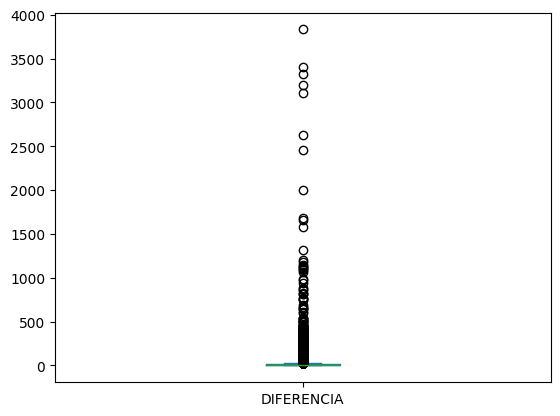

In [19]:
ingresos_ultimos_20d_2024['DIFERENCIA'].plot(kind='box')

In [29]:
Q1 = ingresos_ultimos_20d_2024['DIFERENCIA'].quantile(0.25)
Q3 = ingresos_ultimos_20d_2024['DIFERENCIA'].quantile(0.75)
IQR = Q3 - Q1

filtro = (ingresos_ultimos_20d_2024['DIFERENCIA'] >= Q1 - 1.5 * IQR) & (ingresos_ultimos_20d_2024['DIFERENCIA'] <= Q3 + 1.5 * IQR)
ingresos_ultimos_20d_2024_filtrado = ingresos_ultimos_20d_2024.loc[filtro]  

<Axes: >

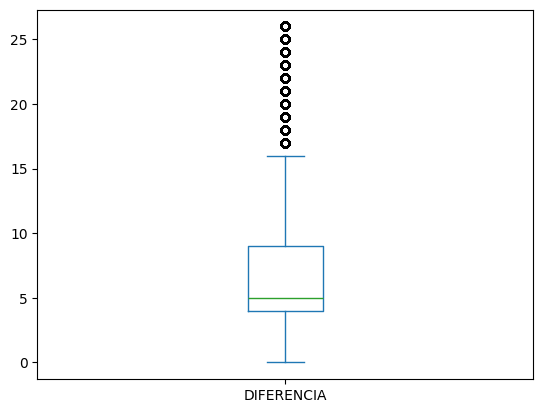

In [30]:
ingresos_ultimos_20d_2024_filtrado['DIFERENCIA'].plot(kind='box')

<Axes: ylabel='Frequency'>

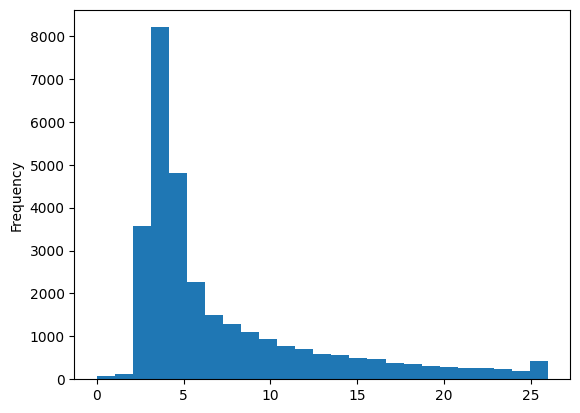

In [39]:
ingresos_ultimos_20d_2024_filtrado['DIFERENCIA'].plot(kind='hist', bins=25)

<Axes: ylabel='Density'>

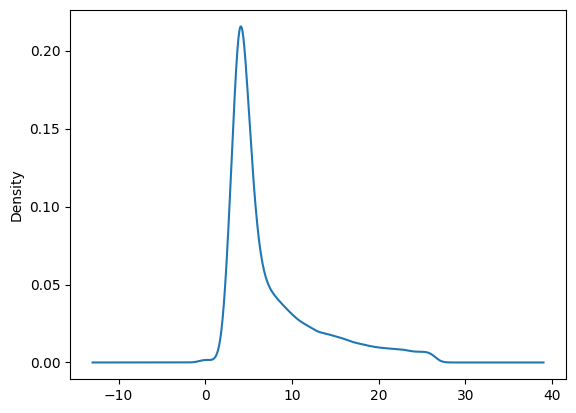

In [36]:
ingresos_ultimos_20d_2024_filtrado['DIFERENCIA'].plot(kind='kde')

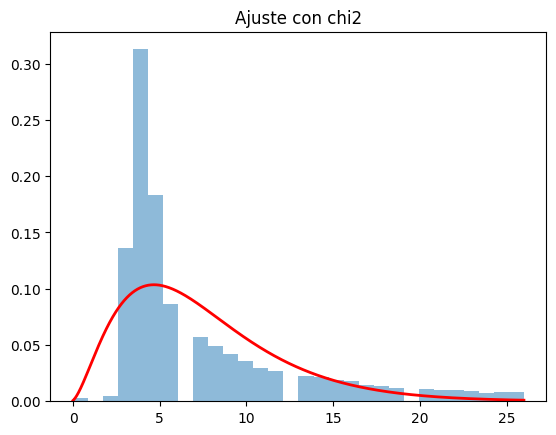

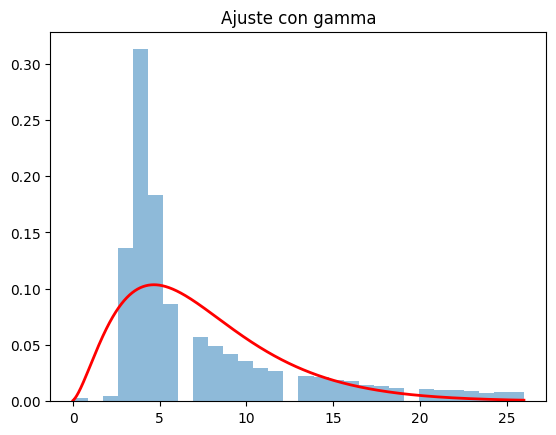

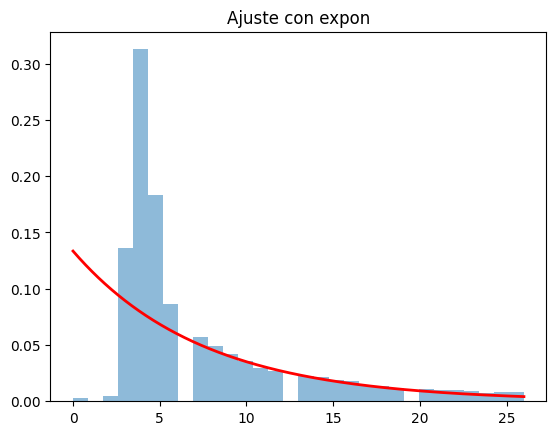

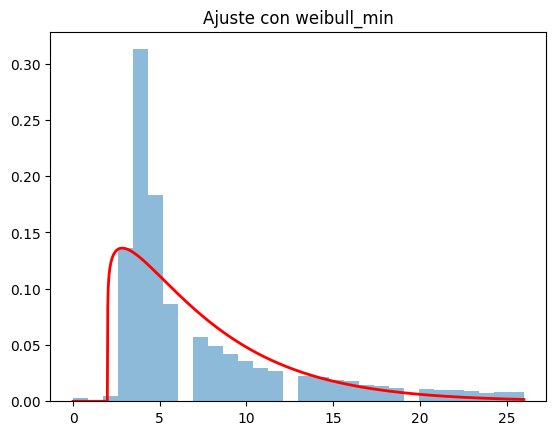

/home/codespace/.local/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:6556: RuntimeWarning: overflow encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)
/home/codespace/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


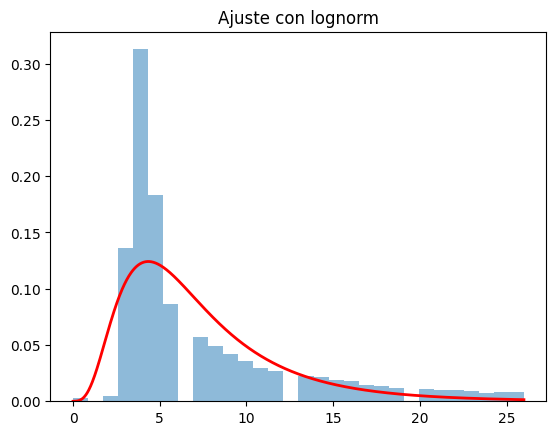

In [37]:
import scipy.stats as st
import matplotlib.pyplot as plt
import numpy as np

# Obtén los datos de la columna que te interesa
datos = ingresos_ultimos_20d_2024_filtrado['DIFERENCIA']

# Define las distribuciones a probar
distribuciones = [st.chi2, st.gamma, st.expon, st.weibull_min, st.lognorm]

# Para cada distribución
for distribucion in distribuciones:
    # Ajusta los datos a la distribución
    parametros = distribucion.fit(datos)
    
    # Crea una figura y un eje para el gráfico
    fig, ax = plt.subplots(1, 1)
    
    # Genera una serie de valores x
    x = np.linspace(min(datos), max(datos), 1000)
    
    # Genera los valores y de la PDF ajustada
    y = distribucion.pdf(x, *parametros)
    
    # Grafica los datos y la PDF ajustada
    ax.hist(datos, bins=30, density=True, alpha=0.5)
    ax.plot(x, y, 'r-', lw=2)
    
    # Muestra el gráfico
    plt.title(f'Ajuste con {distribucion.name}')
    plt.show()

In [42]:
ingresos_ultimos_20d_2024['DIFERENCIA'].describe()

count    34273.000000
mean        16.049923
std         62.914857
min          0.000000
25%          4.000000
50%          6.000000
75%         13.000000
max       3832.000000
Name: DIFERENCIA, dtype: float64

In [40]:
ingresos_ultimos_20d_2024_filtrado['DIFERENCIA'].describe()

count    30262.000000
mean         7.492135
std          5.365907
min          0.000000
25%          4.000000
50%          5.000000
75%          9.000000
max         26.000000
Name: DIFERENCIA, dtype: float64